# TNEG Geospatial Data Preparation

The purpose of this notebook is to aggregate and join all of our TN spatial and non-spatial data. Though it contains a base map with county-level breakdown for the state of TN, its purpose is to get all of the data aggregated at county level. The TNEG Geospatial Visualization Notebook contains the maps built off of these data. 

The following dataframes have been joined together:  
* ``usgs`` Earthquakes in and around TN since 1900 (from the USGS API)
* ``TN_demo`` TN county-level demographic information including total population, % of children (under 18), % of people living in rural or isolated settings, % of people of color, % of people with disabilities, and % of senior citizens (from the TN Arts Commission, derived from the 2010 US census)
* ``TN_housing_units_by_county`` TN county-level aggregates of total population and number of housing units (from the 2010 census)
* ``acs_data`` TN county-level demographic stats
* ``svi`` The CDC's Social Vulnerability Index, with additional demographics
* ``gdp`` TN county-level GDP from 2018

In [1]:
# import statements
import pandas as pd
import numpy as np
import requests
import ipywidgets as widgets
from IPython.core.display import HTML
import matplotlib as mpl
import json
from io import StringIO
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.io import shapereader
%matplotlib inline

In [2]:
# display settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Create a base map for the state of TN, broken down by county, for future spatial joins.

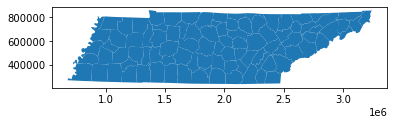

In [3]:
# Ask Michael, get this county-level base map shapefile instead
tn_county_map = gpd.read_file('../data/TN-county-basemap/tncounty.shp')
# See what the map looks like
tn_county_map.plot();

In [4]:
# Take a look at the base map dataframe
tn_county_map.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ..."
2,78,Tipton,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774...."
3,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ..."
4,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ..."


In [5]:
# Check to make sure nothing is missing
tn_county_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    95 non-null     int64   
 1   NAME        95 non-null     object  
 2   KEY         95 non-null     object  
 3   SHAPE_AREA  95 non-null     float64 
 4   SHAPE_LEN   95 non-null     float64 
 5   geometry    95 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 4.6+ KB


In [6]:
# check the projection type
tn_county_map.crs

<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Tennessee
- bounds: (-90.31, 34.98, -81.65, 36.68)
Coordinate Operation:
- name: SPCS83 Tennessee zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
# change the projection type
tn_county_map = tn_county_map.to_crs('EPSG:4326')
print(tn_county_map.crs)
# Clean up some of the columns we don't need
tn_county_map = tn_county_map.drop(['OBJECTID', 'KEY', 'SHAPE_LEN'], axis = 1)
# Reformat column headers
tn_county_map.columns = ['county', 'shape_area', 'geometry']
# Set the county names to lower case
tn_county_map['county'] = tn_county_map['county'].str.lower()
# Make sure the base map dataset is good to go
tn_county_map.head(2)

EPSG:4326


,county,shape_area,geometry
0,chester,8.049024e+09,"POLYGON ((-88.78177 35.24759, -88.78185 35.247..."
1,wayne,2.050741e+10,"POLYGON ((-88.02474 35.39231, -88.02237 35.390..."


### Read in the Wikipedia Deadly Earthquakes since 1900 dataframe, just for fun.

In [8]:
# earthquakes = pd.read_csv('../data/earthquakes_wikitable.csv')
# earthquakes.head()

In [9]:
# Check the data types
# earthquakes.info()

In [10]:
# Set the origin_utc column to a datetime
# earthquakes['origin_utc'] = pd.to_datetime(earthquakes['origin_utc'])
# Create 
# earthquakes['magnitude_type'] = earthquakes['magnitude'].str.extract(r'.*?(\w+)$')
# Clean up the lat/long columns
# earthquakes['latitude'] = earthquakes['lat'].str.replace('?','')
# earthquakes['longitude'] = earthquakes['long'].str.replace('?','')
# Turn the lat/long into floats
# earthquakes['latitude'] = pd.to_numeric(earthquakes['latitude'], errors = 'raise')
# earthquakes['longitude'] = pd.to_numeric(earthquakes['longitude'], errors = 'raise')
# Remove excess columns
# earthquakes = earthquakes.drop(['date_ymd', 'time', 'lat', 'long', 'magnitude', 'pde_shaking_deaths', 'pde_total_deaths', 'utsu_total_deaths', 'em_dat_total_deaths', 'other_source_deaths', 'other_source_deaths_new', 'osd1', 'osd2', 'osd3'], axis = 1)
# Reorder columns
# earthquakes = earthquakes[['origin_utc', 'country', 'latitude', 'longitude', 'depth_km', 'magnitude_num', 'magnitude_type', 'secondary_effects', 'max_deaths']]
# Make sure the data types are correct
# earthquakes.info()

In [11]:
# # Create a new column named 'geometry' which combines the latitude and longitude
# earthquakes['geometry'] = earthquakes.apply(lambda x: Point((float(x.longitude),
#                                                             float(x.latitude))),
#                                            axis = 1)
# earthquakes.head()

In [12]:
# # Turn the Wikipedia Deadly Earthquakes since 1900 table into a Geo Data Frame
# earthquakes_geo = gpd.GeoDataFrame(earthquakes,
#                                    crs = tn_county_map.crs,
#                                    geometry = earthquakes['geometry'])

The Wikipedia deadly earthquakes since 1900 table is now ready for a spatial join.

### Next, pull in the USGS data for earthquakes in TN and turn it into a Geo DataFrame.  

Use the coordinates in this [gist](https://gist.github.com/jakebathman/719e8416191ba14bb6e700fc2d5fccc5) to only get earthquakes from near TN.

In [13]:
# Set the query URL
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=1900-01-01&endtime=2020-10-22&minlatitude=34.9884&maxlatitude=36.6871&minlongitude=-90.3131&maxlongitude=-81.6518'
# Assign the response to a variable
r = requests.get(url)

In [14]:
# Read in the text of the response into a dataframe called usgs
usgs = pd.read_csv(StringIO(r.text))
# See what gets returned
usgs.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2020-10-21T21:49:45.720Z,36.070500,-89.802333,6.84,2.14,md,46.0,40.0,0.06430,0.10,nm,nm60312762,2020-10-22T12:49:53.160Z,"2 km NNE of Cooter, Missouri",earthquake,0.17,0.49,0.092,31.0,reviewed,nm,nm
1,2020-10-21T20:28:42.930Z,36.525000,-89.569167,6.85,1.69,md,19.0,50.0,0.02596,0.03,nm,nm60312752,2020-10-22T14:45:56.660Z,"3 km E of Marston, Missouri",earthquake,0.34,0.63,0.167,12.0,reviewed,nm,nm
2,2020-10-21T04:55:51.350Z,36.545667,-89.649000,8.01,1.61,md,24.0,44.0,0.02245,0.04,nm,nm60312697,2020-10-21T13:04:57.100Z,"4 km NW of Marston, Missouri",earthquake,0.44,0.40,0.147,21.0,reviewed,nm,nm
3,2020-10-21T03:00:08.800Z,36.313667,-89.536167,9.50,1.23,md,17.0,65.0,0.02693,0.06,nm,nm60312692,2020-10-21T13:18:24.430Z,"7 km NW of Ridgely, Tennessee",earthquake,0.68,0.51,0.032,10.0,reviewed,nm,nm
4,2020-10-20T18:50:21.800Z,36.267500,-89.523333,8.84,2.33,md,46.0,33.0,0.01520,0.11,nm,nm60312672,2020-10-21T12:29:35.220Z,"3 km W of Ridgely, Tennessee",earthquake,0.15,0.30,0.142,34.0,reviewed,nm,nm


In [15]:
# Make sure all of the fields are the proper data types
usgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9163 entries, 0 to 9162
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             9163 non-null   object 
 1   latitude         9163 non-null   float64
 2   longitude        9163 non-null   float64
 3   depth            9150 non-null   float64
 4   mag              9160 non-null   float64
 5   magType          9152 non-null   object 
 6   nst              6155 non-null   float64
 7   gap              6153 non-null   float64
 8   dmin             5979 non-null   float64
 9   rms              6164 non-null   float64
 10  net              9163 non-null   object 
 11  id               9163 non-null   object 
 12  updated          9163 non-null   object 
 13  place            9163 non-null   object 
 14  type             9163 non-null   object 
 15  horizontalError  6214 non-null   float64
 16  depthError       6213 non-null   float64
 17  magError      

In [16]:
# Remove excess columns
usgs = usgs.drop(['nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'status', 'locationSource', 'magSource'], axis = 1)
usgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9163 entries, 0 to 9162
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       9163 non-null   object 
 1   latitude   9163 non-null   float64
 2   longitude  9163 non-null   float64
 3   depth      9150 non-null   float64
 4   mag        9160 non-null   float64
 5   magType    9152 non-null   object 
 6   place      9163 non-null   object 
 7   type       9163 non-null   object 
dtypes: float64(4), object(4)
memory usage: 572.8+ KB


In [17]:
# Create a geometry column
usgs['geometry'] = usgs.apply(lambda x: Point((float(x.longitude),
                                            float(x.latitude))),
                              axis = 1)
# Make sure it worked
usgs.head()

,time,latitude,longitude,depth,mag,magType,place,type,geometry
0,2020-10-21T21:49:45.720Z,36.070500,-89.802333,6.84,2.14,md,"2 km NNE of Cooter, Missouri",earthquake,POINT (-89.8023333 36.0705)
1,2020-10-21T20:28:42.930Z,36.525000,-89.569167,6.85,1.69,md,"3 km E of Marston, Missouri",earthquake,POINT (-89.5691667 36.525)
2,2020-10-21T04:55:51.350Z,36.545667,-89.649000,8.01,1.61,md,"4 km NW of Marston, Missouri",earthquake,POINT (-89.649 36.5456667)
3,2020-10-21T03:00:08.800Z,36.313667,-89.536167,9.50,1.23,md,"7 km NW of Ridgely, Tennessee",earthquake,POINT (-89.5361667 36.3136667)
4,2020-10-20T18:50:21.800Z,36.267500,-89.523333,8.84,2.33,md,"3 km W of Ridgely, Tennessee",earthquake,POINT (-89.5233333 36.2675)


In [18]:
# Subset to earthquakes that have happened within TN only, based on the place name
# Not actually necessary if we're going to plot points based on lat/long
# usgs_tn = usgs[usgs['place'].str.contains('(Tennessee)')]
# usgs_tn.info()

In [19]:
# Turn the USGS dataframe into a Geo DataFrame
usgs_geo = gpd.GeoDataFrame(usgs,
                            crs = tn_county_map.crs,
                            geometry = usgs['geometry'])

The usgs dataframe is now ready for a spatial join.

### Make the MMIVI dataset a Geo DataFrame

In [20]:
mmivi = pd.read_csv('../data/prob_mmi_vi_100_yrs.csv')
mmivi.head()

,lon,lat,PctProb100yrs
0,-125.0,50.0,30.27
1,-124.9,50.0,29.00
2,-124.8,50.0,35.98
3,-124.7,50.0,24.64
4,-124.6,50.0,27.86


In [21]:
mmivi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156861 entries, 0 to 156860
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lon            156861 non-null  float64
 1   lat            156861 non-null  float64
 2   PctProb100yrs  156861 non-null  float64
dtypes: float64(3)
memory usage: 3.6 MB


In [22]:
# Create a geometry column
mmivi['geometry'] = mmivi.apply(lambda x: Point((float(x.lon),
                                            float(x.lat))),
                              axis = 1)
# Make sure it worked
mmivi.head()

,lon,lat,PctProb100yrs,geometry
0,-125.0,50.0,30.27,POINT (-125 50)
1,-124.9,50.0,29.00,POINT (-124.9 50)
2,-124.8,50.0,35.98,POINT (-124.8 50)
3,-124.7,50.0,24.64,POINT (-124.7 50)
4,-124.6,50.0,27.86,POINT (-124.6 50)


In [23]:
# create an mmivi_geo dataset
mmivi_geo = gpd.GeoDataFrame(mmivi,
                            crs = tn_county_map.crs,
                            geometry = mmivi['geometry'])

The mmivi dataset is now ready for a spatial join.

### Read in the TN demographics data by county

In [24]:
tn_demo = pd.read_csv('../data/TN-county-demographics-2010.csv')
# Check the top of the tn_demo dataframe
tn_demo.head()

,County,Total Population,Children\n(under 18),People Living in Rural or Isolated settings,People of Color,Disabilities*,Senior Citizens
0,Anderson,"75,129",21.90%,34.66%,6.80%,18.60%,17.40%
1,Bedford,"45,058",26.80%,55.60%,16%,15.70%,12.90%
2,Benton,"16,489",20.50%,78.46%,3.90%,24.60%,19.90%
3,Bledsoe,"12,876",21.50%,100.00%,6.40%,30%,15.40%
4,Blount,"123,010",22.30%,32.63%,5.60%,14.80%,16.10%


In [25]:
# lower case the county to avoid merge errors
tn_demo['County'] = tn_demo['County'].str.lower()
# Rename columns
tn_demo.columns = ['county', 'total_pop', 'pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens']
# Drop total_pop since we're getting the population estimate elsewhere
tn_demo = tn_demo.drop('total_pop', axis = 1)
tn_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   county                            95 non-null     object
 1   pct_children_under_18             95 non-null     object
 2   pct_people_living_in_rural_areas  95 non-null     object
 3   pct_people_of_color               95 non-null     object
 4   pct_people_with_disabilities      95 non-null     object
 5   pct_senior_citizens               95 non-null     object
dtypes: object(6)
memory usage: 4.6+ KB


In [26]:
# remove non-numeric characters from the columns
tn_demo[['pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens']] = tn_demo[['pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens']].apply(lambda x: x.str.replace('%',''))
# Not necessary since we dropped the column
# tn_demo.total_pop = tn_demo.total_pop.str.replace(',','')
tn_demo

,county,pct_children_under_18,pct_people_living_in_rural_areas,pct_people_of_color,pct_people_with_disabilities,pct_senior_citizens
0,anderson,21.90,34.66,6.80,18.60,17.40
1,bedford,26.80,55.60,16,15.70,12.90
2,benton,20.50,78.46,3.90,24.60,19.90
3,bledsoe,21.50,100.00,6.40,30,15.40
4,blount,22.30,32.63,5.60,14.80,16.10
5,bradley,23.00,32.97,8.60,18.10,14.10
6,campbell,22.00,55.02,2.10,22.80,17.20
7,cannon,22.50,81.13,3.10,18.40,16.10
8,carroll,21.90,83.06,12.20,21.20,17.90
9,carter,20.10,40.97,3.10,22.40,17.10


In [27]:
tn_demo[['pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens']] = tn_demo[['pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens']].apply(pd.to_numeric, errors = 'raise')
tn_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   county                            95 non-null     object 
 1   pct_children_under_18             95 non-null     float64
 2   pct_people_living_in_rural_areas  95 non-null     float64
 3   pct_people_of_color               95 non-null     float64
 4   pct_people_with_disabilities      95 non-null     float64
 5   pct_senior_citizens               95 non-null     float64
dtypes: float64(5), object(1)
memory usage: 4.6+ KB


The TN demographics dataframe is now ready for a non-spatial join.

### Read in and clean up the census housing units by county for TN data.

In [28]:
# Only read in the relevant lines of the csv
tn_housing = pd.read_csv('../data/us_census_tn_housing_units_by_county_2010-2019.csv')[2:99]

In [29]:
# Use the first row as the column headers
tn_housing.columns = tn_housing.iloc[0]
# Remove the excess lines from the dataframe
tn_housing = tn_housing[2:99]

In [30]:
# Reset the index
tn_housing = tn_housing.reset_index(drop = True)
tn_housing

2,NaN,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,".Anderson County, Tennessee","34,717","34,700","34,709","34,774","34,763","34,758","34,783","34,872","34,913","34,962","35,029","35,143"
1,".Bedford County, Tennessee","18,360","18,360","18,403","18,503","18,537","18,580","18,631","18,775","18,913","19,082","19,300","19,531"
2,".Benton County, Tennessee","8,975","8,975","8,977","8,984","9,040","9,049","9,061","9,069","9,083","9,108","9,147","9,172"
3,".Bledsoe County, Tennessee","5,718","5,720","5,724","5,708","5,717","5,726","5,735","5,743","5,755","5,769","5,785","5,796"
4,".Blount County, Tennessee","55,266","55,303","55,342","55,474","55,594","55,856","56,413","56,689","57,026","57,498","58,390","58,942"
5,".Bradley County, Tennessee","41,395","41,378","41,427","41,740","41,950","42,177","42,428","42,903","43,412","43,719","44,118","44,532"
6,".Campbell County, Tennessee","19,966","19,970","20,011","20,116","20,222","20,326","20,454","20,583","20,750","20,937","21,157","21,394"
7,".Cannon County, Tennessee","6,037","6,043","6,046","6,055","6,066","6,080","6,094","6,108","6,122","6,142","6,164","6,164"
8,".Carroll County, Tennessee","13,184","13,167","13,189","13,238","13,241","13,240","13,242","13,243","13,249","13,259","13,271","13,273"
9,".Carter County, Tennessee","27,746","27,730","27,747","27,849","27,887","27,908","27,970","27,983","28,059","28,178","28,263","28,350"


In [31]:
# Drop the excess columns
tn_housing = tn_housing.drop(['Census', 'Estimates Base', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'], axis = 1)
# Rename the columns
tn_housing.columns = ['county', 'total_housing_units_2019']
# Clean up and standardize the county names
tn_housing['county'] = tn_housing['county'].str.extract(r'\.(.*) County, Tennessee')
tn_housing['county'] = tn_housing['county'].str.lower()
tn_housing['total_housing_units_2019'] = tn_housing['total_housing_units_2019'].str.replace(',','')
tn_housing['total_housing_units_2019'] = pd.to_numeric(tn_housing['total_housing_units_2019'], errors = 'raise')

In [32]:
tn_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   county                    95 non-null     object
 1   total_housing_units_2019  95 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


The TN housing units dataset is now ready to join.

### Read in the ACS dataframe

In [33]:
acs = pd.read_csv('../data/acs_5yr_subset_clean.csv')
acs.head()

,geo_id,county_full,county,population_est,pct_insured,race_afam,race_asam,race_latn,race_natam,race_paci,race_white,race_othr,race_multi,disability_y,disability_n,edu_lessHS,edu_HSgrad,edu_assoc,edu_min_bac,employed_est,unemployed_est,tot_w_poverty_lvl_data,tot_poverty_less100,tot_poverty_101_138,tot_poverty_138_399,tot_poverty_400_up
0,0500000US47001,"Anderson County, Tennessee",anderson,74862,90.8,2365,1018,2094,377,29,66911,637,2021,14157,60705,6828,17453,15622,12480,30244,1969,74292,12022,5901,33240,23129
1,0500000US47003,"Bedford County, Tennessee",bedford,47184,88.7,3384,79,5682,27,29,36541,2404,1495,7526,39658,5814,12314,7346,4999,19883,940,46923,7420,4105,24435,10963
2,0500000US47005,"Benton County, Tennessee",benton,15960,90.3,507,34,274,69,0,14835,0,285,4297,11663,2161,5447,2519,1404,5185,443,15922,3403,2114,7145,3260
3,0500000US47007,"Bledsoe County, Tennessee",bledsoe,13436,87.0,347,8,252,223,0,12220,23,371,3603,9833,2489,3692,2362,1390,5367,527,13391,2721,1342,6438,2890
4,0500000US47009,"Blount County, Tennessee",blount,127292,91.2,3328,993,4145,369,127,116154,259,2481,18304,108988,9548,30868,26997,21624,54149,2857,126101,14808,8975,59213,43105


In [34]:
# Get rid of a column that isn't useful
acs = acs.drop('geo_id', axis = 1)
acs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   county_full             95 non-null     object 
 1   county                  95 non-null     object 
 2   population_est          95 non-null     int64  
 3   pct_insured             95 non-null     float64
 4   race_afam               95 non-null     int64  
 5   race_asam               95 non-null     int64  
 6   race_latn               95 non-null     int64  
 7   race_natam              95 non-null     int64  
 8   race_paci               95 non-null     int64  
 9   race_white              95 non-null     int64  
 10  race_othr               95 non-null     int64  
 11  race_multi              95 non-null     int64  
 12  disability_y            95 non-null     int64  
 13  disability_n            95 non-null     int64  
 14  edu_lessHS              95 non-null     int6

The ACS data has already been cleaned and is ready for a non-spatial join.

### Read in the CDC Social Vulnerability Index dataframe

From [here](https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html)

In [35]:
# Only read in the Social Vulnerability Index scores for the counties in TN
svi = pd.read_csv('../data/TN-vulnerability-scores.csv', usecols=['COUNTY','AREA_SQMI','RPL_THEME1','RPL_THEME2','RPL_THEME3','RPL_THEME4','RPL_THEMES', 'EP_UNINSUR'])
svi.head()

,COUNTY,AREA_SQMI,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,EP_UNINSUR
0,Moore,129.222493,0.0638,0.0532,0.1170,0.0213,0.0000,10.7
1,Williamson,582.866127,0.0000,0.0213,0.7447,0.0000,0.0106,4.9
2,Smith,314.294959,0.1596,0.4362,0.1383,0.0532,0.0213,8.7
3,Wilson,571.091033,0.0106,0.1064,0.7766,0.0426,0.0319,6.6
4,Fayette,704.774920,0.1702,0.0745,0.6383,0.0106,0.0426,7.6


In [36]:
svi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   COUNTY      95 non-null     object 
 1   AREA_SQMI   95 non-null     float64
 2   RPL_THEME1  95 non-null     float64
 3   RPL_THEME2  95 non-null     float64
 4   RPL_THEME3  95 non-null     float64
 5   RPL_THEME4  95 non-null     float64
 6   RPL_THEMES  95 non-null     float64
 7   EP_UNINSUR  95 non-null     float64
dtypes: float64(7), object(1)
memory usage: 6.1+ KB


In [37]:
# rename the columns
svi.columns = ['county', 'area_miles2', 'socioeconomic', 'household_comp_and_disability', 'minority_status_and_language', 'housing_type_and_transportation', 'total_vulnerability', 'pct_uninsured']
svi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   county                           95 non-null     object 
 1   area_miles2                      95 non-null     float64
 2   socioeconomic                    95 non-null     float64
 3   household_comp_and_disability    95 non-null     float64
 4   minority_status_and_language     95 non-null     float64
 5   housing_type_and_transportation  95 non-null     float64
 6   total_vulnerability              95 non-null     float64
 7   pct_uninsured                    95 non-null     float64
dtypes: float64(7), object(1)
memory usage: 6.1+ KB


In [38]:
# convert the county to lowercase to facilitate joins
svi['county'] = svi['county'].str.lower()

In [39]:
# sort the dataset by the county, then reset the index
svi = svi.sort_values('county').reset_index(drop=True)
svi

,county,area_miles2,socioeconomic,household_comp_and_disability,minority_status_and_language,housing_type_and_transportation,total_vulnerability,pct_uninsured
0,anderson,337.203175,0.2128,0.6277,0.6596,0.6489,0.4043,9.2
1,bedford,473.638959,0.3511,0.6915,0.9681,0.5319,0.6809,11.3
2,benton,394.306039,0.8085,0.7766,0.2553,0.6277,0.7766,9.7
3,bledsoe,406.424786,0.8723,0.1809,0.8085,0.9681,0.9574,13.0
4,blount,558.816658,0.0426,0.0426,0.5426,0.1702,0.0745,8.8
5,bradley,328.761662,0.3298,0.3936,0.8404,0.8830,0.5638,11.8
6,campbell,480.162536,0.8404,0.9255,0.0213,0.6596,0.7660,11.3
7,cannon,265.635253,0.2766,0.1489,0.1702,0.3085,0.1064,10.1
8,carroll,597.657317,0.6170,0.8298,0.4043,0.9149,0.8191,8.1
9,carter,341.258169,0.6489,0.6489,0.1489,0.7447,0.5319,11.9


The svi dataset is ready to join.

### Read in the TN County-Level GDP Data

In [40]:
# Create a list of column names
columns = ['geofips', 'geoname', '2014', '2015', '2016', '2017', '2018']
# Read in the csv, trim off the footnotes and the excess stuff at the top, pass in the list of column names
tn_gdp = pd.read_csv('../data/tn_county_gdp_2014_2018.csv', names=columns)[6:-4]
# Do some column cleanup
tn_gdp = tn_gdp.drop(['geofips', '2014', '2015', '2016', '2017'], axis=1)
tn_gdp = tn_gdp.rename(columns={'geoname':'county', '2018':'gdp_2018'}).reset_index(drop=True)
tn_gdp

,county,gdp_2018
0,"Anderson, TN",4770850.0
1,"Bedford, TN",1824402.0
2,"Benton, TN",386699.0
3,"Bledsoe, TN",224732.0
4,"Blount, TN",5384691.0
5,"Bradley, TN",4907911.0
6,"Campbell, TN",917213.0
7,"Cannon, TN",272721.0
8,"Carroll, TN",770399.0
9,"Carter, TN",1173099.0


In [41]:
# Get only the county name, make it lowercase for joining
tn_gdp['county'] = tn_gdp['county'].str.extract(r'(.*), TN')
tn_gdp['county'] = tn_gdp['county'].str.lower()
tn_gdp

,county,gdp_2018
0,anderson,4770850.0
1,bedford,1824402.0
2,benton,386699.0
3,bledsoe,224732.0
4,blount,5384691.0
5,bradley,4907911.0
6,campbell,917213.0
7,cannon,272721.0
8,carroll,770399.0
9,carter,1173099.0


The GDP dataset is ready to join.

### Aggregate the USGS earthquake data by county

This will allow us to map the earthquakes at a county level

In [42]:
# Join the USGS data to the basic TN basemap, where the points are within each county
tn_earthquakes_by_county = gpd.sjoin(usgs_geo, tn_county_map, op = 'within')
tn_earthquakes_by_county

,time,latitude,longitude,depth,mag,magType,place,type,geometry,index_right,county,shape_area
3,2020-10-21T03:00:08.800Z,36.313667,-89.536167,9.50,1.23,md,"7 km NW of Ridgely, Tennessee",earthquake,POINT (-89.53617 36.31367),24,lake,5.402735e+09
4,2020-10-20T18:50:21.800Z,36.267500,-89.523333,8.84,2.33,md,"3 km W of Ridgely, Tennessee",earthquake,POINT (-89.52333 36.26750),24,lake,5.402735e+09
6,2020-10-19T20:31:16.660Z,36.419667,-89.499000,7.78,1.30,md,"5 km NNW of Tiptonville, Tennessee",earthquake,POINT (-89.49900 36.41967),24,lake,5.402735e+09
16,2020-10-12T11:33:20.900Z,36.345000,-89.516667,5.33,1.33,md,"5 km SW of Tiptonville, Tennessee",earthquake,POINT (-89.51667 36.34500),24,lake,5.402735e+09
17,2020-10-12T05:37:13.920Z,36.297167,-89.535667,10.26,1.45,md,"5 km NW of Ridgely, Tennessee",earthquake,POINT (-89.53567 36.29717),24,lake,5.402735e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
7442,1984-06-17T17:05:47.900Z,35.390000,-88.780000,5.00,2.00,md,"13km WSW of Henderson, Tennessee",earthquake,POINT (-88.78000 35.39000),0,chester,8.049024e+09
7491,1984-01-17T02:36:13.540Z,35.435000,-88.087000,8.10,2.20,md,"9km WNW of Clifton, Tennessee",earthquake,POINT (-88.08700 35.43500),52,decatur,9.615720e+09
8614,1978-02-15T18:06:58.100Z,35.710000,-88.070000,5.00,2.20,mlg,"8km NE of Parsons, Tennessee",earthquake,POINT (-88.07000 35.71000),52,decatur,9.615720e+09
7538,1983-08-27T01:25:50.800Z,35.065000,-89.369000,2.60,1.80,md,"19km S of Somerville, Tennessee",earthquake,POINT (-89.36900 35.06500),88,fayette,1.969005e+10


In [43]:
# Aggregate relevant magnitude, depth, and overall earthquake counts to visualize
tn_earthquakes_by_county = tn_earthquakes_by_county.groupby('county') \
    .agg({'mag':['mean', 'median', 'max'], 
         'depth':['mean', 'median', 'min'],
         'geometry':'count'})

In [44]:
# Check out the dataframe
tn_earthquakes_by_county

mag                   depth                geometry
                mean median   max       mean  median    min    count
county                                                              
anderson    1.820000  1.725  2.23  15.995000  15.185  12.98        4
bedford     2.770000  2.770  2.77   6.520000   6.520   6.52        1
bledsoe     1.656667  1.650  2.50  17.120556  17.105   4.38       18
blount      1.918889  1.920  4.70  12.531778  13.060   0.04      135
bradley     1.995278  2.010  3.50  14.438889  12.095   1.80       36
campbell    2.373571  2.400  3.80  20.656429  19.875   4.20       14
carroll     1.950000  1.950  2.20   5.100000   5.100   5.00        2
chester     2.000000  2.000  2.00   5.000000   5.000   5.00        1
claiborne   2.263529  2.160  4.10  14.467059  15.480   0.00       17
cocke       2.275000  2.275  2.35  10.780000  10.780   3.82        2
coffee      2.550000  2.550  2.55   6.450000   6.450   6.45        1
crockett    1.970000  1.900  2.31   7.033333   5.000   1.10        3
cumberland  2.033333  1.900  2.70   4.910000   5.000   3.77        3
decatur     2.200000  2.200  2.20   6.550000   6.550   5.00        2
dyer        1.694503  1.600  4.50   7.934517   7.700   0.33      644
fayette     1.750000  1.750  1.80   3.800000   3.800   2.60        2
fentress    2.500000  2.500  2.50  20.600000  20.600  20.60        1
franklin    2.955000  2.955  3.13   7.455000   7.455   6.48        2
gibson      2.021429  2.050  3.10   9.280000   7.460   4.38       14
giles       2.153333  2.100  2.36   9.870000   9.980   8.20        3
grainger    2.135172  2.110  4.10  11.993571  11.360   0.14       29
greene      2.294000  2.080  4.50   6.147000   4.970   2.33       10
grundy      1.747500  1.700  2.29  14.277500  13.780   9.59        4
hamblen     2.020000  2.200  2.48   2.702000   1.010   0.22        5
hamilton    1.999286  2.060  3.00  12.300000  11.260   0.11       28
hancock     2.400000  2.400  3.00   6.795000   6.795   0.00        2
hardeman    1.900000  1.900  1.90  10.000000  10.000  10.00        1
hardin      2.300000  2.600  2.70   2.970000   2.630   1.62        4
hawkins     2.240000  2.270  2.58  23.423333  22.740  12.61        3
haywood     2.000000  2.000  2.30  12.935000  12.935   6.47        2
henderson   2.296667  2.400  2.40  12.433333  11.830  10.02        3
henry       2.230000  2.230  2.23  25.350000  25.350  25.35        1
hickman     2.100000  2.100  2.10   2.200000   2.200   2.20        1
jefferson   2.211429  2.490  3.30  13.203571  13.250   5.00       14
johnson     2.900000  2.900  3.10   8.633333  10.570   3.73        3
knox        2.096780  2.020  3.70  13.866102  14.790   1.57       59
lake        1.530109  1.500  3.30   6.815432   6.770   0.00     2118
lauderdale  2.133250  2.025  4.00   8.385000   7.850   2.20       40
lawrence    2.093333  2.175  2.31   5.700000   5.600   2.00        6
lincoln     2.400000  2.400  2.90   8.325000   8.325   7.00        2
loudon      1.602100  1.615  2.73  14.940900  15.885   0.02      100
marion      1.859091  1.900  2.57  13.498182  10.970   6.78       11
mcminn      1.681758  1.700  3.30  14.652747  14.890   5.14       91
meigs       2.313571  2.110  4.40  10.025714   6.250   2.32       28
monroe      1.766667  1.740  4.20  14.005000  13.340   1.25      210
montgomery  0.000000  0.000  0.00   5.000000   5.000   5.00        1
morgan      1.995714  2.000  2.53  12.090000  10.320   5.55        7
obion       1.601151  1.510  3.30   6.849872   6.990   0.08      391
perry       2.166667  2.000  2.50   4.466667   5.000   3.30        3
pickett     2.400000  2.400  2.40   7.020000   7.020   7.02        1
polk        1.914348  1.950  2.80  13.426250  11.935   5.00       24
rhea        1.894737  1.900  2.80  17.146842  18.915   5.38       38
roane       1.977143  2.100  3.30  16.030857  16.690   3.90       35
scott       1.150000  1.150  2.30  11.675000  11.675   5.00        2
sequatchie  1.680000  1.600  2.50  16.894000  17.040  13.37        5
sevier      2.0

In [45]:
# Fix the multiindex
tn_earthquakes_by_county.columns =  ['_'.join(col).strip() for col in tn_earthquakes_by_county.columns.values]
tn_earthquakes_by_county.columns

Index(['mag_mean', 'mag_median', 'mag_max', 'depth_mean', 'depth_median', 'depth_min', 'geometry_count'], dtype='object')

In [46]:
# Rename the number of earthquakes column
tn_earthquakes_by_county = tn_earthquakes_by_county.rename(columns = {'geometry_count':'num_earthquakes'})

In [47]:
# Move the counties from the index to a column
tn_earthquakes_by_county.reset_index(inplace = True)
tn_earthquakes_by_county

,county,mag_mean,mag_median,mag_max,depth_mean,depth_median,depth_min,num_earthquakes
0,anderson,1.820000,1.725,2.23,15.995000,15.185,12.98,4
1,bedford,2.770000,2.770,2.77,6.520000,6.520,6.52,1
2,bledsoe,1.656667,1.650,2.50,17.120556,17.105,4.38,18
3,blount,1.918889,1.920,4.70,12.531778,13.060,0.04,135
4,bradley,1.995278,2.010,3.50,14.438889,12.095,1.80,36
5,campbell,2.373571,2.400,3.80,20.656429,19.875,4.20,14
6,carroll,1.950000,1.950,2.20,5.100000,5.100,5.00,2
7,chester,2.000000,2.000,2.00,5.000000,5.000,5.00,1
8,claiborne,2.263529,2.160,4.10,14.467059,15.480,0.00,17
9,cocke,2.275000,2.275,2.35,10.780000,10.780,3.82,2


In [48]:
tn_earthquakes_by_county.columns

Index(['county', 'mag_mean', 'mag_median', 'mag_max', 'depth_mean', 'depth_median', 'depth_min', 'num_earthquakes'], dtype='object')

The aggregated-by-county USGS dataset is ready for a non-spatial join.

### Read in, and aggregate to the TN county level, the change of a potentially damaging ground shaking in 100 years dataset

In [49]:
# Join the MMIVI data to the basic TN basemap, where the points are within each county
tn_earthquake_prob_by_county = gpd.sjoin(mmivi_geo, tn_county_map, op = 'within')
tn_earthquake_prob_by_county = tn_earthquake_prob_by_county.drop(['lon', 'lat', 'index_right', 'shape_area'], axis = 1)

In [50]:
tn_earthquake_prob_by_county = tn_earthquake_prob_by_county.rename(columns = {'PctProb100yrs':'pct_prob_100y'})

In [51]:
tn_earthquake_prob_by_county

,pct_prob_100y,geometry,county
80904,28.78,POINT (-88.00000 36.60000),stewart
80905,27.82,POINT (-87.90000 36.60000),stewart
80906,29.12,POINT (-87.80000 36.60000),stewart
80907,29.44,POINT (-87.70000 36.60000),stewart
81505,28.03,POINT (-88.00000 36.50000),stewart
...,...,...,...
89955,20.63,POINT (-84.40000 35.10000),polk
90553,19.60,POINT (-84.70000 35.00000),polk
90554,19.47,POINT (-84.60000 35.00000),polk
90555,19.12,POINT (-84.50000 35.00000),polk


In [52]:
# Aggregate relevant magnitude, depth, and overall earthquake counts to visualize
tn_earthquake_prob_by_county = tn_earthquake_prob_by_county.groupby('county') \
    .agg({'pct_prob_100y':['median', 'max']})
tn_earthquake_prob_by_county

pct_prob_100y       
                  median    max
county                         
anderson          16.680  23.48
bedford           16.470  19.56
benton            30.180  32.83
bledsoe           18.310  24.48
blount            23.800  30.84
bradley           25.130  30.39
campbell          14.455  16.57
cannon            12.190  19.46
carroll           33.390  38.82
carter             9.255  13.20
cheatham          19.770  23.47
chester           28.435  31.48
claiborne         15.580  20.37
clay               9.870  17.54
cocke             14.695  21.35
coffee            18.705  20.25
crockett          43.055  47.40
cumberland        17.210  23.39
davidson          17.710  22.92
decatur           24.865  29.65
dekalb            11.330  17.96
dickson           21.045  25.22
dyer              55.630  59.93
fayette           33.545  39.92
fentress          13.930  20.11
franklin          13.555  21.06
gibson            42.140  50.07
giles             15.120  21.81
grainger          16.685  21.06
greene            15.455  19.72
grundy            17.570  22.60
hamblen           16.205  16.92
hamilton          18.850  27.20
hancock           14.680  16.17
hardeman          29.630  33.25
hardin            23.855  28.66
hawkins           12.875  18.98
haywood           40.250  45.82
henderson         30.430  33.99
henry             35.170  39.09
hickman           19.680  26.39
houston           24.750  29.69
humphreys         23.710  29.83
jackson           10.835  19.14
jefferson         19.630  22.35
johnson            8.300   8.73
knox              22.145  29.02
lake              60.610  61.42
lauderdale        48.255  54.39
lawrence          20.390  23.05
lewis             20.560  24.63
lincoln           16.570  20.73
loudon            26.145  29.22
macon             15.580  18.50
madison           34.280  37.95
marion            15.910  23.99
marshall          15.810  21.85
maury             18.635  22.86
mcminn            24.010  33.15
mcnairy           25.760  29.73
meigs             21.680  25.10
monroe            26.360  33.08
montgomery        23.660  30.11
moore             15.850  17.60
morgan            15.730  23.97
obion             51.300  57.28
overton           11.435  16.96
perry             21.450  26.73
pickett           10.170  13.59
polk              20.760  27.20
putnam            15.295  19.50
rhea              21.090  26.87
roane             18.840  25.77
robertson         20.900  24.34
rutherford        19.100  21.14
scott             12.755  16.52
sequatchie        16.170  18.87
sevier            17.240  23.34
shelby            36.370  41.26
smith             10.995  12.18
stewart           26.980  29.79
sullivan          10.060  12.10
sumner            14.750  20.82
tipton            42.450  45.99
trousdale         11.130  12.49
unicoi            10.600  11.08
union             16.440  19.59
van buren         14.430  22.33
warren            19.190  20.84
washington        11.940  16.99
wayne             19.150  23.05
weakley           42.320  45.69
white             17.545  21.97
williamson        17.420  22.12
wilson            15.450  20.21

In [53]:
# Fix the multiindex
tn_earthquake_prob_by_county.columns =  ['_'.join(col).strip() for col in tn_earthquake_prob_by_county.columns.values]
tn_earthquake_prob_by_county.columns

Index(['pct_prob_100y_median', 'pct_prob_100y_max'], dtype='object')

In [54]:
# Move the counties from the index to a column
tn_earthquake_prob_by_county.reset_index(inplace = True)
tn_earthquake_prob_by_county

,county,pct_prob_100y_median,pct_prob_100y_max
0,anderson,16.680,23.48
1,bedford,16.470,19.56
2,benton,30.180,32.83
3,bledsoe,18.310,24.48
4,blount,23.800,30.84
5,bradley,25.130,30.39
6,campbell,14.455,16.57
7,cannon,12.190,19.46
8,carroll,33.390,38.82
9,carter,9.255,13.20


The probability dataset is ready to join.

### Merge the non-spatial dataframes together  

Merge on the county level to build the framework for mapping the data.

In [55]:
# Join the demographics and housing data into one dataframe
tn_housing_demo = tn_demo.merge(tn_housing, how = 'outer', on = 'county')
tn_housing_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   county                            95 non-null     object 
 1   pct_children_under_18             95 non-null     float64
 2   pct_people_living_in_rural_areas  95 non-null     float64
 3   pct_people_of_color               95 non-null     float64
 4   pct_people_with_disabilities      95 non-null     float64
 5   pct_senior_citizens               95 non-null     float64
 6   total_housing_units_2019          95 non-null     int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 5.9+ KB


In [56]:
tn_housing_demo_acs = tn_housing_demo.merge(acs, how = 'outer', on = 'county')
tn_housing_demo_acs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   county                            95 non-null     object 
 1   pct_children_under_18             95 non-null     float64
 2   pct_people_living_in_rural_areas  95 non-null     float64
 3   pct_people_of_color               95 non-null     float64
 4   pct_people_with_disabilities      95 non-null     float64
 5   pct_senior_citizens               95 non-null     float64
 6   total_housing_units_2019          95 non-null     int64  
 7   county_full                       95 non-null     object 
 8   population_est                    95 non-null     int64  
 9   pct_insured                       95 non-null     float64
 10  race_afam                         95 non-null     int64  
 11  race_asam                         95 non-null     int64  
 12  race_latn 

In [57]:
tn_housing_demo_acs_svi = tn_housing_demo_acs.merge(svi, how = 'outer', on = 'county')
tn_housing_demo_acs_svi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   county                            95 non-null     object 
 1   pct_children_under_18             95 non-null     float64
 2   pct_people_living_in_rural_areas  95 non-null     float64
 3   pct_people_of_color               95 non-null     float64
 4   pct_people_with_disabilities      95 non-null     float64
 5   pct_senior_citizens               95 non-null     float64
 6   total_housing_units_2019          95 non-null     int64  
 7   county_full                       95 non-null     object 
 8   population_est                    95 non-null     int64  
 9   pct_insured                       95 non-null     float64
 10  race_afam                         95 non-null     int64  
 11  race_asam                         95 non-null     int64  
 12  race_latn 

In [58]:
tn_housing_demo_acs_svi_gdp = tn_housing_demo_acs_svi.merge(tn_gdp, how = 'outer', on = 'county')
tn_housing_demo_acs_svi_gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   county                            95 non-null     object 
 1   pct_children_under_18             95 non-null     float64
 2   pct_people_living_in_rural_areas  95 non-null     float64
 3   pct_people_of_color               95 non-null     float64
 4   pct_people_with_disabilities      95 non-null     float64
 5   pct_senior_citizens               95 non-null     float64
 6   total_housing_units_2019          95 non-null     int64  
 7   county_full                       95 non-null     object 
 8   population_est                    95 non-null     int64  
 9   pct_insured                       95 non-null     float64
 10  race_afam                         95 non-null     int64  
 11  race_asam                         95 non-null     int64  
 12  race_latn 

In [59]:
# Create a gdp_per_capita column
tn_housing_demo_acs_svi_gdp['gdp_per_cap_2018'] = tn_housing_demo_acs_svi_gdp['gdp_2018'] / tn_housing_demo_acs_svi_gdp['population_est']
tn_housing_demo_acs_svi_gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   county                            95 non-null     object 
 1   pct_children_under_18             95 non-null     float64
 2   pct_people_living_in_rural_areas  95 non-null     float64
 3   pct_people_of_color               95 non-null     float64
 4   pct_people_with_disabilities      95 non-null     float64
 5   pct_senior_citizens               95 non-null     float64
 6   total_housing_units_2019          95 non-null     int64  
 7   county_full                       95 non-null     object 
 8   population_est                    95 non-null     int64  
 9   pct_insured                       95 non-null     float64
 10  race_afam                         95 non-null     int64  
 11  race_asam                         95 non-null     int64  
 12  race_latn 

In [60]:
# Join the USGS county-level aggregate dataset to the TN non-spatial dataset
tn_housing_demo_acs_svi_gdp_earthquakes = tn_housing_demo_acs_svi_gdp.merge(tn_earthquakes_by_county, how = 'left', on = 'county')
tn_housing_demo_acs_svi_gdp_earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   county                            95 non-null     object 
 1   pct_children_under_18             95 non-null     float64
 2   pct_people_living_in_rural_areas  95 non-null     float64
 3   pct_people_of_color               95 non-null     float64
 4   pct_people_with_disabilities      95 non-null     float64
 5   pct_senior_citizens               95 non-null     float64
 6   total_housing_units_2019          95 non-null     int64  
 7   county_full                       95 non-null     object 
 8   population_est                    95 non-null     int64  
 9   pct_insured                       95 non-null     float64
 10  race_afam                         95 non-null     int64  
 11  race_asam                         95 non-null     int64  
 12  race_latn 

In [61]:
tn_housing_demo_acs_svi_gdp_earthquakes_probs = tn_housing_demo_acs_svi_gdp_earthquakes.merge(tn_earthquake_prob_by_county, how = 'left', on = 'county')
tn_housing_demo_acs_svi_gdp_earthquakes_probs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   county                            95 non-null     object 
 1   pct_children_under_18             95 non-null     float64
 2   pct_people_living_in_rural_areas  95 non-null     float64
 3   pct_people_of_color               95 non-null     float64
 4   pct_people_with_disabilities      95 non-null     float64
 5   pct_senior_citizens               95 non-null     float64
 6   total_housing_units_2019          95 non-null     int64  
 7   county_full                       95 non-null     object 
 8   population_est                    95 non-null     int64  
 9   pct_insured                       95 non-null     float64
 10  race_afam                         95 non-null     int64  
 11  race_asam                         95 non-null     int64  
 12  race_latn 

In [62]:
# Rename the dataset something easier to reference
tn_data = tn_housing_demo_acs_svi_gdp_earthquakes_probs

In [63]:
tn_data.to_csv('../data/TN_aggregated_data.csv')